### <center> **Análise Preditiva:** Música

**Objetivo:** Prever a música que será a mais escutada ao final do ano. Retornar também as top 5 músicas.

In [123]:
# Importações
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from prophet import Prophet


In [96]:
# Lê o csv com o gênero das músicas
df = pd.read_csv('C:/Users/sofiasantana-ieg/OneDrive - Instituto Germinare/3º TECH AD/Ciência de Dados/VsCode/Analise Preditiva/spotify_songs_giovanne.csv')

### Compreensão dos Dados

In [97]:
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6189 entries, 0 to 6188
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ts                                 6189 non-null   object 
 1   platform                           6189 non-null   object 
 2   ms_played                          6189 non-null   int64  
 3   conn_country                       6189 non-null   object 
 4   ip_addr                            6189 non-null   object 
 5   master_metadata_track_name         6189 non-null   object 
 6   master_metadata_album_artist_name  6189 non-null   object 
 7   master_metadata_album_album_name   6189 non-null   object 
 8   spotify_track_uri                  6189 non-null   object 
 9   episode_name                       0 non-null      float64
 10  episode_show_name                  0 non-null      float64
 11  spotify_episode_uri                0 non-null      float

,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,audiobook_chapter_uri,audiobook_chapter_title,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode,genero
0,2025-07-01T11:18:37Z,windows,5658,BR,170.85.20.197,Stop Crying Your Heart Out,Oasis,Heathen Chemistry,spotify:track:5YciOakY5dB5dULkiLdCaf,NaN,...,NaN,NaN,remote,switched-to-video,True,False,False,1751368710,False,britpop
1,2025-07-01T11:23:39Z,windows,296006,BR,170.85.20.197,Stop Crying Your Heart Out,Oasis,Heathen Chemistry,spotify:track:5YciOakY5dB5dULkiLdCaf,NaN,...,NaN,NaN,switched-to-audio,trackdone,True,False,False,1751368723,False,britpop
2,2025-07-01T11:27:20Z,windows,220497,BR,170.85.20.197,tv off (feat. lefty gunplay),Kendrick Lamar,GNX,spotify:track:0aB0v4027ukVziUGwVGYpG,NaN,...,NaN,NaN,trackdone,trackdone,True,False,False,1751369019,False,hip hop
3,2025-07-01T11:31:17Z,windows,236646,BR,170.85.20.197,Cocoon,Catfish and the Bottlemen,The Balcony,spotify:track:1B241LRKmK6qDDTZfUajmm,NaN,...,NaN,NaN,trackdone,trackdone,True,False,False,1751369240,False,indie
4,2025-07-01T11:35:18Z,windows,240315,BR,170.85.20.197,Sweater Weather,The Neighbourhood,I Love You.,spotify:track:2QjOHCTQ1Jl3zawyYOpxh6,NaN,...,NaN,NaN,trackdone,trackdone,True,False,False,1751369478,False,indie


### Preparação de Dados

In [98]:
# COlunas necessárias: ts, ms_played, master_metadata_album_master_metadata_track_name, master_metadata_album_artist_name, shuffle, skipped

# Copiando os dados para outro df
df_music = df.copy()

# Excluindo colunas desnecessárias
df_music = df_music.drop(columns=['platform', 'conn_country', 'ip_addr', 'master_metadata_album_album_name', 'spotify_track_uri', 'episode_name', 'episode_show_name', 'spotify_episode_uri', 'audiobook_uri', 'audiobook_title', 'audiobook_chapter_uri', 'audiobook_chapter_title', 'reason_start', 'reason_end', 'offline', 'offline_timestamp', 'incognito_mode', 'genero'])

# df limpo
display(df_music.head())

,ts,ms_played,master_metadata_track_name,master_metadata_album_artist_name,shuffle,skipped
0,2025-07-01T11:18:37Z,5658,Stop Crying Your Heart Out,Oasis,True,False
1,2025-07-01T11:23:39Z,296006,Stop Crying Your Heart Out,Oasis,True,False
2,2025-07-01T11:27:20Z,220497,tv off (feat. lefty gunplay),Kendrick Lamar,True,False
3,2025-07-01T11:31:17Z,236646,Cocoon,Catfish and the Bottlemen,True,False
4,2025-07-01T11:35:18Z,240315,Sweater Weather,The Neighbourhood,True,False


In [ ]:
# apagar do df as músicas que foram puladas e estavam no modo aleatório
df_music.drop(
    df_music[(df_music['shuffle'] == True) & (df_music['skipped'] == True)].index, 
    inplace=True)

display(df_music.head())


,ts,ms_played,master_metadata_track_name,master_metadata_album_artist_name,shuffle,skipped
0,2025-07-01T11:18:37Z,5658,Stop Crying Your Heart Out,Oasis,True,False
1,2025-07-01T11:23:39Z,296006,Stop Crying Your Heart Out,Oasis,True,False
2,2025-07-01T11:27:20Z,220497,tv off (feat. lefty gunplay),Kendrick Lamar,True,False
3,2025-07-01T11:31:17Z,236646,Cocoon,Catfish and the Bottlemen,True,False
4,2025-07-01T11:35:18Z,240315,Sweater Weather,The Neighbourhood,True,False


In [100]:
# Converter timestamp
df_music['ts'] = pd.to_datetime(df['ts'])

# Criar colunas úteis
df_music['ano'] = df_music['ts'].dt.year
df_music['mes'] = df_music['ts'].dt.to_period('M')

# Converter ms_played para minutos
df_music['min_played'] = df_music['ms_played'] / 60000

display(df_music)


C:\Users\sofiasantana-ieg\AppData\Local\Temp\ipykernel_14600\2352705225.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_music['mes'] = df_music['ts'].dt.to_period('M')


,ts,ms_played,master_metadata_track_name,master_metadata_album_artist_name,shuffle,skipped,ano,mes,min_played
0,2025-07-01 11:18:37+00:00,5658,Stop Crying Your Heart Out,Oasis,True,False,2025,2025-07,0.094300
1,2025-07-01 11:23:39+00:00,296006,Stop Crying Your Heart Out,Oasis,True,False,2025,2025-07,4.933433
2,2025-07-01 11:27:20+00:00,220497,tv off (feat. lefty gunplay),Kendrick Lamar,True,False,2025,2025-07,3.674950
3,2025-07-01 11:31:17+00:00,236646,Cocoon,Catfish and the Bottlemen,True,False,2025,2025-07,3.944100
4,2025-07-01 11:35:18+00:00,240315,Sweater Weather,The Neighbourhood,True,False,2025,2025-07,4.005250
...,...,...,...,...,...,...,...,...,...
6184,2026-01-29 19:13:50+00:00,105619,Crazy Dave (In-Game),Laura Shigihara,True,False,2026,2026-01,1.760317
6185,2026-01-29 19:16:46+00:00,177427,I Can Talk,Two Door Cinema Club,True,False,2026,2026-01,2.957117
6186,2026-01-29 19:21:20+00:00,276200,"If You Were There, Beware",Arctic Monkeys,True,False,2026,2026-01,4.603333
6187,2026-01-29 19:24:14+00:00,175373,Epitáfio,Titãs,True,False,2026,2026-01,2.922883


### Features

In [124]:
# Agregação mensal por música
df_month = (
    df_music.groupby(['mes', 'master_metadata_track_name'])
      ['min_played'].sum()
      .reset_index()
)

df_month['mes'] = df_month['mes'].dt.to_timestamp()

display(df_month.head())

,mes,master_metadata_track_name,min_played
0,2025-07-01,0520,1.458417
1,2025-07-01,10 Carros,2.352933
2,2025-07-01,16 Years,3.762000
3,2025-07-01,19-2000 - Soulchild Remix,0.161167
4,2025-07-01,1901,9.655300


### Modelo

In [ ]:
resultados = []
avaliacoes = []

for musica in df_month['master_metadata_track_name'].unique():

    # Filtrar música corretamente
    df_tmp = df_month[
        df_month['master_metadata_track_name'] == musica
    ][['mes', 'min_played']].copy()

    # Renomear colunas
    df_tmp.columns = ['ds', 'y']

    # Converter para Timestamp 
    df_tmp['ds'] = pd.to_datetime(df_tmp['ds'])
    # Remover NaNs
    df_tmp = df_tmp.dropna()

    # Ordenar por data
    df_tmp = df_tmp.sort_values('ds')

    # Evitar séries muito curtas
    if len(df_tmp) < 3:
        continue

    # Divisão de treino e teste
    n_test = 1
    train = df_tmp.iloc[:-n_test]
    test = df_tmp.iloc[-n_test:]

    # Modelo
    model = Prophet()
    model.fit(train)

    future = model.make_future_dataframe(periods=n_test, freq='M')
    forecast = model.predict(future)

    # Avaliação
    y_true = test['y'].values
    y_pred = forecast.tail(n_test)['yhat'].values

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    avaliacoes.append([musica, mae, rmse])

    # Previsão final
    previsao_final = forecast.tail(1)['yhat'].values[0]

    resultados.append([musica, previsao_final])

21:26:53 - cmdstanpy - INFO - Chain [1] start processing
21:26:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\sofiasantana-ieg\AppData\Roaming\Python\Python311\site-packages\prophet\forecaster.py:1875: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
21:26:53 - cmdstanpy - INFO - Chain [1] start processing
21:26:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\sofiasantana-ieg\AppData\Roaming\Python\Python311\site-packages\prophet\forecaster.py:1875: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
21:26:54 - cmdstanpy - INFO - Chain [1] start processing
21:26:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\sofiasantana-ieg\AppData\Roaming\Python\Python311\site-packages\prophet\forecaster.py:1875: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = p

### Resultado das Avaliações

In [125]:
avaliacoes_ordenadas = sorted(avaliacoes, key=lambda x: x[1], reverse=False)

print(f"{'Música':<50} | {'MAE':^7} | {'RMSE'}")
for avaliacao in avaliacoes_ordenadas:
    print(f"{avaliacao[0]:<50} | {round(avaliacao[1], 4):^7} | {round(avaliacao[2], 4)}")

Música                                             |   MAE   | RMSE
Boulevard of Broken Dreams                         |   0.0   | 0.0
Fluorescent Adolescent                             |   0.0   | 0.0
Fly Away                                           |   0.0   | 0.0
Give It Away                                       |   0.0   | 0.0
Grannies World Tour                                |   0.0   | 0.0
Já Sei Namorar - 2004 Digital Remaster             |   0.0   | 0.0
Man in the Box                                     |   0.0   | 0.0
Quatro Vezes Você                                  |   0.0   | 0.0
The Final Countdown                                |   0.0   | 0.0
Volta Pra Mim                                      |   0.0   | 0.0
What's My Age Again?                               |   0.0   | 0.0
Youth                                              |   0.0   | 0.0
Faint                                              |   0.0   | 0.0
MORE THAN YOU KNOW                                 |   0.0   

### Resultado do Modelo (Previsão)

In [122]:
df_result = pd.DataFrame(resultados, columns=['musica', 'previsao_minutos'])

top5 = df_result.sort_values('previsao_minutos', ascending=False).head(5)

print(top5)

                       musica  previsao_minutos
132             November Rain         49.926445
141                       One         48.605911
155               Radio/Video         44.923313
197  The Day That Never Comes         39.179703
98                 Iridescent         37.247988


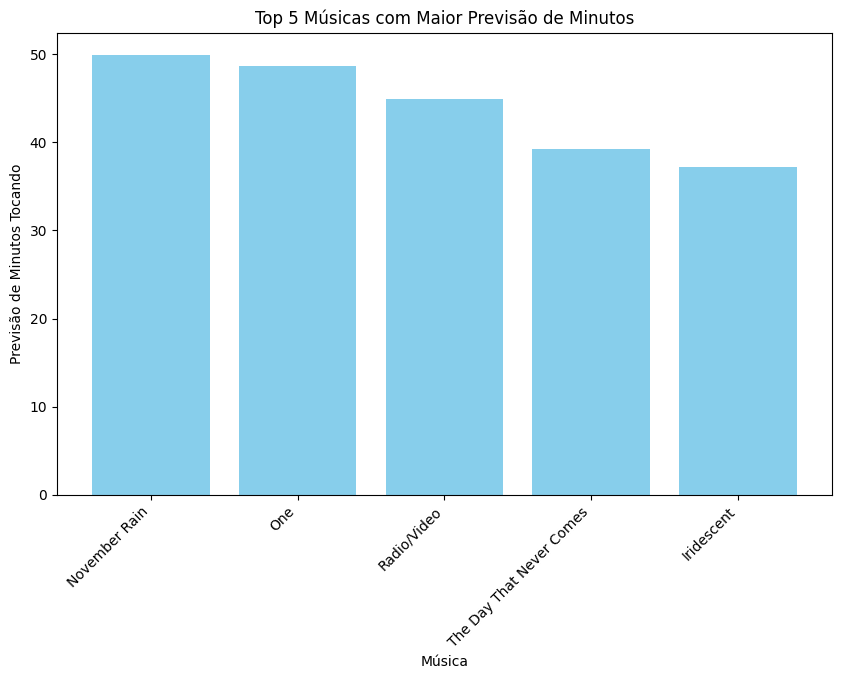

In [149]:
# Gráfico
plt.figure(figsize=(10, 6))
plt.bar(top5['musica'], top5['previsao_minutos'], color='skyblue')
plt.title('Top 5 Músicas com Maior Previsão de Minutos')
plt.xlabel('Música')
plt.ylabel('Previsão de Minutos Tocando')
plt.xticks(rotation=45, ha='right')
plt.show()